In [2]:
import requests
import pandas as pd
import geopandas as gpd
from shapely import wkt
import itertools
import seaborn as sns

In [3]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = []

get_tract_vars = ['C02003_' + str(i).zfill(3) + 'E' for i in range(1, 20) ]
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'tract:*'  ## Census tracts
predicates['in']  = 'state:47'  ## State of Tennessee

request = requests.get(base_url, params=predicates)
col_names = ['NAME', 'Total', 'One Race', 'White', 'Black', 'Amerindian', 'Asian', 'Hawaiian Pac Islander', 'Other',
             'Two Or More', 'Two Or More Incl Other', 'Two Not Other Not More', 
             'Two Races Total', 'White Black', 'White Amerindian', 'White Asian', 'Black Amerindian', 'Other Combos', 'Three', 'Four',
             'state', 'county', 'tract']
census_df = pd.DataFrame(columns=col_names, data=request.json()[1:])
census_df = census_df[census_df['county'] == '037']
census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract']
census_df = census_df.drop(['NAME'], axis=1)
census_df = census_df.dropna()
census_df['Total'] = census_df['Total'].astype('int')  ## Make numeric cols numeric

## USE IF PULLING IN ADDITIONAL CENSUS DATA THAT NEEDS TO BE TRANSLATED TO PERCENT##
##col_names_core = ["Owner Occupied", "Renter Occupied"]
##for col in col_names_core:
##    census_df["Pct_" + col] = 100 * census_df[col] / census_df["Total"]

In [15]:
census_df.head()
census_df.drop(['state', 'county', 'tract'], axis=1, inplace=True)
census_df.rename({'Total': 'Total Pop'}, inplace=True)
census_df.head()

,Total,One Race,White,Black,Amerindian,Asian,Hawaiian Pac Islander,Other,Two Or More,Two Or More Incl Other,Two Not Other Not More,Two Races Total,White Black,White Amerindian,White Asian,Black Amerindian,Other Combos,Three,Four,GEOID
482,1983,1905,1166,674,0,0,0,65,78,0,78,78,57,9,12,0,0,0,0,47037010302
483,3893,3679,2935,643,0,0,9,92,214,0,214,214,42,49,25,0,98,0,0,47037011200
484,6123,5974,2928,2139,0,0,0,907,149,22,127,149,105,22,0,0,22,0,0,47037010402
485,5617,5485,4391,988,0,7,0,99,132,8,124,132,104,20,0,0,8,0,0,47037010502
486,3006,3006,521,2471,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,47037010904


In [5]:
## Download shape file found at https://www.census.gov/cgi-bin/geo/shapefiles/index.php
## 2019 - Census Tracts
tract_shape = gpd.read_file('../data/tl_2019_47_tract.shp') 
tract_shape = tract_shape[tract_shape['COUNTYFP'] == '037']  ## Reduce to Davidson County


In [6]:
print(tract_shape.crs)

epsg:4269


In [7]:
nash_cncl_dist_shape = gpd.read_file('../data/council_districts_shape.csv')
nash_cncl_dist_shape['geometry'] = nash_cncl_dist_shape['Boundary']
nash_cncl_dist_shape['geometry'] = nash_cncl_dist_shape['geometry'].apply(wkt.loads)
nash_cncl_dist_shape = nash_cncl_dist_shape.drop(columns=['Boundary'])

nu_nash_cncl_dist_shape = nash_cncl_dist_shape.set_crs('EPSG:4269')
print(nu_nash_cncl_dist_shape.crs)

#print(nu_nash_cncl_dist_shape['geometry'])

#print(nur_nash_cncl_dist_shape.crs)

EPSG:4269


C:\Users\Kyle\.conda\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [8]:
print(nu_nash_cncl_dist_shape.shape)
print(tract_shape.shape)


(35, 6)
(161, 13)


In [9]:
all_together_now = gpd.overlay(nu_nash_cncl_dist_shape, tract_shape, how='union')

<AxesSubplot:>

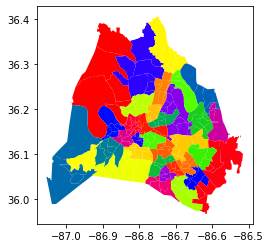

In [10]:
cmap=sns.color_palette(palette='prism', n_colors=35, as_cmap=True)
all_together_now.plot(cmap=cmap, column='District')

In [11]:
all_together_now.to_csv('all_out.csv')

In [13]:
all_together_calcs = all_together_now.copy()
all_together_calcs.to_crs('epsg:3857')

,District,Last Name,First Name,Email Address,Business Phone,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,615-432-1301,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677.0,6845.0,+36.2610013,-086.8023491,"MULTIPOLYGON (((-9664927.285 4331190.735, -966..."
1,2,Toombs,KyonztÃ©,Kyonzte.Toombs@nashville.gov,615-432-1302,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677.0,6845.0,+36.2610013,-086.8023491,"MULTIPOLYGON (((-9661199.454 4332930.079, -966..."
2,3,Gamble,Jennifer,Jennifer.Gamble@nashville.gov,615-432-1303,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677.0,6845.0,+36.2610013,-086.8023491,"POLYGON ((-9661199.298 4332931.301, -9661200.7..."
3,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,615-432-1301,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418.0,61097.0,+36.3444054,-086.8608396,"POLYGON ((-9674340.867 4354424.943, -9674320.2..."
4,3,Gamble,Jennifer,Jennifer.Gamble@nashville.gov,615-432-1303,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418.0,61097.0,+36.3444054,-086.8608396,"MULTIPOLYGON (((-9663298.430 4342380.790, -966..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,NaN,NaN,NaN,NaN,NaN,47,037,018904,47037018904,189.04,Census Tract 189.04,G5020,S,2582791.0,0.0,+36.0657785,-086.7267063,"MULTIPOLYGON (((-9653457.896 4309907.358, -965..."
617,NaN,NaN,NaN,NaN,NaN,47,037,018905,47037018905,189.05,Census Tract 189.05,G5020,S,1462431.0,0.0,+36.0593606,-086.7364091,"MULTIPOLYGON (((-9655565.941 4309940.370, -965..."
618,NaN,NaN,NaN,NaN,NaN,47,037,018301,47037018301,183.01,Census Tract 183.01,G5020,S,85850192.0,1506526.0,+36.1502364,-086.9664616,"MULTIPOLYGON (((-9672749.909 4320313.083, -967..."
619,NaN,NaN,NaN,NaN,NaN,47,037,018302,47037018302,183.02,Census Tract 183.02,G5020,S,49978667.0,13533.0,+36.0400075,-087.0145261,"MULTIPOLYGON (((-9681291.540 4304458.457, -968..."


In [16]:
census_w_overlay = all_together_calcs.merge(census_df, how='inner', on='GEOID')
census_w_overlay.head()

,District,Last Name,First Name,Email Address,Business Phone,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,Two Or More Incl Other,Two Not Other Not More,Two Races Total,White Black,White Amerindian,White Asian,Black Amerindian,Other Combos,Three,Four
0,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,615-432-1301,47,037,010106,47037010106,101.06,...,0,62,62,52,0,0,10,0,0,0
1,2,Toombs,KyonztÃ©,Kyonzte.Toombs@nashville.gov,615-432-1302,47,037,010106,47037010106,101.06,...,0,62,62,52,0,0,10,0,0,0
2,3,Gamble,Jennifer,Jennifer.Gamble@nashville.gov,615-432-1303,47,037,010106,47037010106,101.06,...,0,62,62,52,0,0,10,0,0,0
3,NaN,NaN,NaN,NaN,NaN,47,037,010106,47037010106,101.06,...,0,62,62,52,0,0,10,0,0,0
4,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,615-432-1301,47,037,010103,47037010103,101.03,...,0,36,36,25,0,11,0,0,0,0


In [21]:
census_w_overlay.drop(['MTFCC', 'FUNCSTAT', 'NAMELSAD'], axis=1, inplace=True)
census_w_overlay.head()

KeyError: "['STATEFP' 'COUNTYFP' 'TRACTCE' 'NAME' 'Business Phone'] not found in axis"

In [22]:
census_w_overlay.drop(['MTFCC', 'FUNCSTAT', 'NAMELSAD'], axis=1, inplace=True)
census_w_overlay.head()

,District,Last Name,First Name,Email Address,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,...,Two Or More Incl Other,Two Not Other Not More,Two Races Total,White Black,White Amerindian,White Asian,Black Amerindian,Other Combos,Three,Four
0,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,47037010106,21505677.0,6845.0,+36.2610013,-086.8023491,"MULTIPOLYGON (((-86.82152 36.22185, -86.82149 ...",...,0,62,62,52,0,0,10,0,0,0
1,2,Toombs,KyonztÃ©,Kyonzte.Toombs@nashville.gov,47037010106,21505677.0,6845.0,+36.2610013,-086.8023491,"MULTIPOLYGON (((-86.78803 36.23446, -86.78804 ...",...,0,62,62,52,0,0,10,0,0,0
2,3,Gamble,Jennifer,Jennifer.Gamble@nashville.gov,47037010106,21505677.0,6845.0,+36.2610013,-086.8023491,"POLYGON ((-86.78803 36.23446, -86.78804 36.234...",...,0,62,62,52,0,0,10,0,0,0
3,NaN,NaN,NaN,NaN,47037010106,21505677.0,6845.0,+36.2610013,-086.8023491,"MULTIPOLYGON (((-86.79035 36.23328, -86.79035 ...",...,0,62,62,52,0,0,10,0,0,0
4,1,Hall,Jonathan B.,Jonathan.Hall@nashville.gov,47037010103,48020418.0,61097.0,+36.3444054,-086.8608396,"POLYGON ((-86.90608 36.39005, -86.90590 36.389...",...,0,36,36,25,0,11,0,0,0,0
